# Dataset description

Dataset Name: System of Record Timestamps with Anomaly Tracking


There is a very clear pattern in these data if you can make them behave. This media website had a lot of mischevious activity during on their site. They aren't sure why, but they want to know if the activity had a patern to it. Can you find the pattern? Do you have a theory of why we see the pattern?


Columns:

	1.	Record_ID: Unique identifier for each entry.
	2.	Primary_Timestamp: Always present, with varying formats across rows, including:
	•	ISO format (e.g., 2024-10-01T08:30:00Z)
	•	U.S. format with AM/PM (e.g., 10/01/2024 08:30 AM)
	•	European format (e.g., 01-10-2024 08:30)
	3.	Secondary_Timestamp: Sometimes present, formatted differently but consistently when it appears. Examples include:
	•	Unix timestamp (e.g., 1696246200)
	•	Relative time (e.g., 3 days ago or 1 month ago)
	4.	Tertiary_Timestamp: Rarely present and potentially corrupted, with issues like:
	•	Incomplete timestamps (e.g., 2024-10)
	•	Invalid formats (e.g., Oct 1st or 2024/10/01)
	5.	Event_Count: Integer count following a parabolic pattern. It peaks on November 5, 2024, and decreases symmetrically on either side, with dates ranging from October 1, 2024, to January 1, 2025. The parabolic function is set so that Event_Count is highest around November 5 and gradually drops toward both October 1 and January 1.

Objective for Students:

	1.	Parse and Standardize Dates: Students must accurately parse, clean, and standardize the dates across columns.
	2.	Reveal the Parabolic Pattern: When plotting Event_Count over time, students will uncover a parabolic trend centered around November 5, 2024. This exercise highlights the importance of data parsing in visualizing and interpreting patterns, with Event_Count demonstrating a clear peak around a central date.

This setup combines both the technical skill of date parsing and a conceptual understanding of patterns in time-series data, as students work to uncover the parabolic peak around a specific date.

In [19]:
import os
import pandas as pd

os.chdir('/Users/ephraimlove/Courses/data_wrangling/')
df = pd.read_csv('data/assignment_6/system_of_record_timestamps.csv')

df.head()

,Record_ID,Primary_Timestamp,Secondary_Timestamp,Tertiary_Timestamp,Event_Count
0,1,01-10-2024 00:00,NaN,NaN,1
1,2,2024-10-02T00:00:00Z,NaN,NaN,12
2,3,10/03/2024 12:00 AM,1727913600,NaN,12
3,4,10/04/2024 12:00 AM,1728000000,NaN,12
4,5,2024-10-05T00:00:00Z,NaN,NaN,13


In [22]:
from datetime import datetime, timedelta
from dateutil import parser as date_parser

# Function to parse various timestamp formats
def parse_timestamp(timestamp):
    if pd.isna(timestamp):
        return None

    # Try parsing common formats
    try:
        # Attempt ISO and common formats
        return date_parser.parse(timestamp, fuzzy=True)
    except ValueError:
        pass

    # Attempt specific known formats
    known_formats = [
        "%m/%d/%Y %I:%M %p",   # US format with AM/PM
        "%d-%m-%Y %H:%M",      # European format
        "%Y-%m",               # Year and month only
        "%b %d",               # Month and day with potential ambiguity
        "%Y/%d/%m"             # Mixed format with errors
    ]

    for fmt in known_formats:
        try:
            return datetime.strptime(timestamp, fmt)
        except ValueError:
            continue

    # Handle Unix timestamp (if the timestamp is numeric)
    if timestamp.isdigit():
        try:
            return datetime.fromtimestamp(int(timestamp))
        except ValueError:
            pass

    # Handle relative timestamps (e.g., "3 days ago", "2 weeks ago")
    try:
        parts = timestamp.split()
        if "day" in parts:
            days = int(parts[0]) if "ago" in parts else -int(parts[0])
            return datetime.now() - timedelta(days=days)
        elif "week" in parts:
            weeks = int(parts[0]) if "ago" in parts else -int(parts[0])
            return datetime.now() - timedelta(weeks=weeks)
    except (ValueError, IndexError):
        pass

    # Return None if all parsing attempts fail
    return None

# Apply parsing function to each timestamp column
df["Primary_Timestamp_Parsed"] = df["Primary_Timestamp"].apply(parse_timestamp)
df["Secondary_Timestamp_Parsed"] = df["Secondary_Timestamp"].apply(parse_timestamp)
df["Tertiary_Timestamp_Parsed"] = df["Tertiary_Timestamp"].apply(parse_timestamp)

# Display the first few rows to verify parsing results
print(df[["Record_ID", "Primary_Timestamp", "Primary_Timestamp_Parsed", 
          "Secondary_Timestamp", "Secondary_Timestamp_Parsed", 
          "Tertiary_Timestamp", "Tertiary_Timestamp_Parsed"]].head())

   Record_ID     Primary_Timestamp   Primary_Timestamp_Parsed  \
0          1      01-10-2024 00:00        2024-01-10 00:00:00   
1          2  2024-10-02T00:00:00Z  2024-10-02 00:00:00+00:00   
2          3   10/03/2024 12:00 AM        2024-10-03 00:00:00   
3          4   10/04/2024 12:00 AM        2024-10-04 00:00:00   
4          5  2024-10-05T00:00:00Z  2024-10-05 00:00:00+00:00   

  Secondary_Timestamp Secondary_Timestamp_Parsed Tertiary_Timestamp  \
0                 NaN                        NaT                NaN   
1                 NaN                        NaT                NaN   
2          1727913600        2024-10-02 20:00:00                NaN   
3          1728000000        2024-10-03 20:00:00                NaN   
4                 NaN                        NaT                NaN   

  Tertiary_Timestamp_Parsed  
0                       NaT  
1                       NaT  
2                       NaT  
3                       NaT  
4                       NaT  


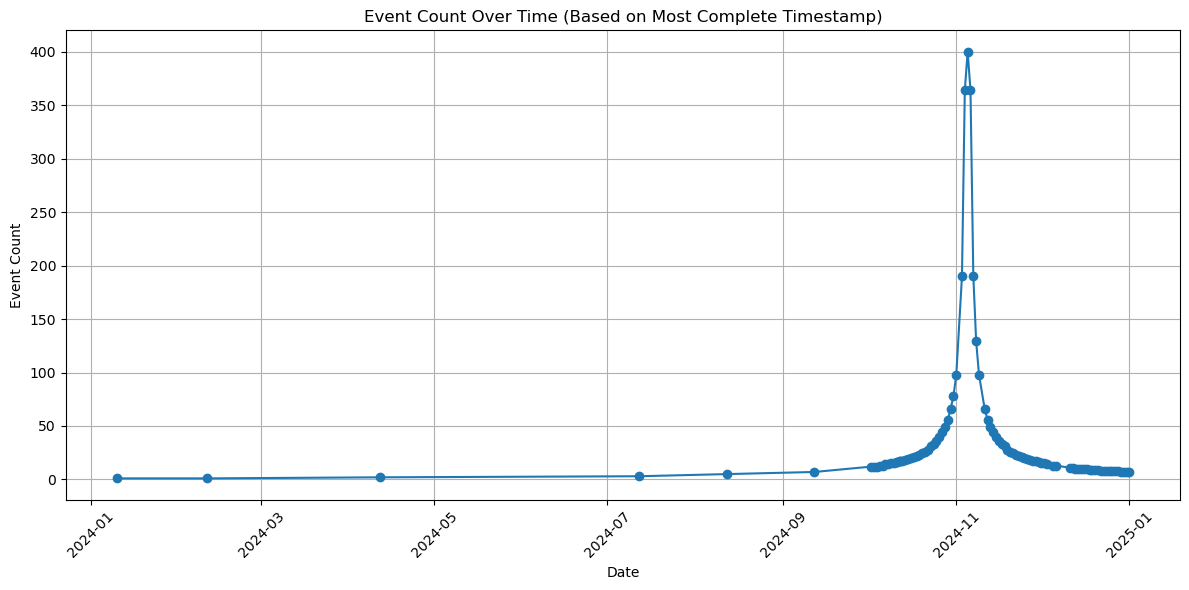

In [23]:
import matplotlib.pyplot as plt

# Create the 'Complete_Timestamp' column by prioritizing available timestamps
df['Complete_Timestamp'] = df['Primary_Timestamp_Parsed'].combine_first(
    df['Secondary_Timestamp_Parsed']).combine_first(df['Tertiary_Timestamp_Parsed'])

# Drop rows without a valid complete timestamp, as they can't be plotted
df = df.dropna(subset=['Complete_Timestamp'])

# Ensure all timestamps in Complete_Timestamp are offset-naive
df['Complete_Timestamp'] = df['Complete_Timestamp'].apply(lambda x: x.replace(tzinfo=None) if x is not None else x)

# Sort by Complete_Timestamp for a time-ordered plot
df = df.sort_values('Complete_Timestamp')

# Plot Event_Count over time
plt.figure(figsize=(12, 6))
plt.plot(df['Complete_Timestamp'], df['Event_Count'], marker='o', linestyle='-')
plt.title("Event Count Over Time (Based on Most Complete Timestamp)")
plt.xlabel("Date")
plt.ylabel("Event Count")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()